# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   
3. Jämför CatBoost med XGBoost GridSearchCV med cross validation för tidsserier

In [45]:
import sklearn

import xgboost as xgb

import catboost
from catboost import CatBoostClassifier

from pytrends.request import TrendReq
import pytrends
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
import google

from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.DEBUG, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [46]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


# Här följer ChatGPT inspirerad kod för att skapa data från yahoo finance

In [47]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [48]:
def import_ticker_data(tickers, ticker_names):
    df = yf.download(tickers, interval='1d',
                       group_by='ticker', auto_adjust=True)
    df = pd.DataFrame(df.xs('Close', level=1, axis=1))
    df.columns = ticker_names
    df.dropna(inplace=True)
    
    df = df.assign(**{ticker_name + '_pct_change': df[ticker_name].pct_change()*100 for ticker_name in ticker_names})
    df.fillna(0, inplace=True)
    # df.dropna(inplace=True)
    
    return df

df = import_ticker_data(tickers, ticker_names)
df.tail(10)

[*********************100%***********************]  5 of 5 completed


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change
Date,,,,,,,,,,
2023-03-17,135.601822,1792.485107,27423.929688,0.380382,0.240443,7.500398,6.872680,9.464577,3.922410,8.058933
2023-03-18,131.309540,1761.659668,26965.878906,0.374433,0.231876,-3.165357,-1.719704,-1.670259,-1.563952,-3.563009
2023-03-19,136.125992,1785.576538,28038.675781,0.388465,0.249997,3.668014,1.357633,3.978349,3.747527,7.814955
2023-03-20,130.603912,1735.321289,27767.236328,0.374628,0.234314,-4.056594,-2.814511,-0.968089,-3.561963,-6.273279
2023-03-21,134.461746,1806.760742,28175.816406,0.469710,0.238597,2.953842,4.116785,1.471447,25.380373,1.827894
2023-03-22,126.236031,1737.717041,27307.437500,0.422480,0.227455,-6.117514,-3.821408,-3.082001,-10.055142,-4.669799
2023-03-23,128.812714,1816.405151,28333.972656,0.444850,0.237676,2.041163,4.528246,3.759178,5.294928,4.493631
2023-03-24,123.892990,1752.044800,27493.285156,0.425902,0.229557,-3.819284,-3.543282,-2.967065,-4.259411,-3.415996
2023-03-25,125.152679,1743.764771,27494.707031,0.444716,0.224970,1.016756,-0.472592,0.005172,4.417447,-1.998194


In [49]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)    
    return df   

def beräkna_cumulative_return(df, ticker_names):
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

df = beräkna_rolling_mean(df, ticker_names, window=20)
display(df)
display(pd.DataFrame(beräkna_cumulative_return(df.query("Date > '2021-04-13'"), ticker_names), index=['cum_ret']))


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,1546.180054,472.902008,10058.799805,0.299152,0.225542,-4.707957,-1.551561,2.448988,17.810235,-3.249444,1313.403958,373.973451,7840.200977,0.231176,0.208566
2017-11-29,1359.709961,427.523010,9888.610352,0.243064,0.190781,-12.060050,-9.595856,-1.691946,-18.748993,-15.412206,1348.674307,379.305402,7977.452490,0.232455,0.206577
2017-11-30,1389.780029,447.114014,10233.599609,0.250878,0.188614,2.211506,4.582444,3.488754,3.214793,-1.135858,1367.792310,386.698453,8158.225464,0.234674,0.206147
2017-12-01,1462.680054,466.540009,10975.599609,0.255699,0.201924,5.245436,4.344752,7.250626,1.921652,7.056741,1373.903815,394.291403,8389.125439,0.236938,0.206385
2017-12-02,1434.979980,463.449005,11074.599609,0.255492,0.211218,-1.893789,-0.662538,0.902001,-0.080957,4.602724,1376.209814,402.068454,8645.351929,0.239846,0.207551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22,126.236031,1737.717041,27307.437500,0.422480,0.227455,-6.117514,-3.821408,-3.082001,-10.055142,-4.669799,124.854782,1632.072064,24045.855371,0.381327,0.227790
2023-03-23,128.812714,1816.405151,28333.972656,0.444850,0.237676,2.041163,4.528246,3.759178,5.294928,4.493631,124.989238,1644.433942,24344.420020,0.384686,0.227119
2023-03-24,123.892990,1752.044800,27493.285156,0.425902,0.229557,-3.819284,-3.543282,-2.967065,-4.259411,-3.415996,124.963162,1653.689984,24601.416797,0.387290,0.226591


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple
cum_ret,-0.847669,-0.277796,-0.560577,-0.757566,-0.894135


In [50]:
pct_list=['Bitcoin_pct_change',	'Ethereum_pct_change',	'Bitcoin Cash_pct_change',	'0X_pct_change',	'Ripple_pct_change'	]
df

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,1546.180054,472.902008,10058.799805,0.299152,0.225542,-4.707957,-1.551561,2.448988,17.810235,-3.249444,1313.403958,373.973451,7840.200977,0.231176,0.208566
2017-11-29,1359.709961,427.523010,9888.610352,0.243064,0.190781,-12.060050,-9.595856,-1.691946,-18.748993,-15.412206,1348.674307,379.305402,7977.452490,0.232455,0.206577
2017-11-30,1389.780029,447.114014,10233.599609,0.250878,0.188614,2.211506,4.582444,3.488754,3.214793,-1.135858,1367.792310,386.698453,8158.225464,0.234674,0.206147
2017-12-01,1462.680054,466.540009,10975.599609,0.255699,0.201924,5.245436,4.344752,7.250626,1.921652,7.056741,1373.903815,394.291403,8389.125439,0.236938,0.206385
2017-12-02,1434.979980,463.449005,11074.599609,0.255492,0.211218,-1.893789,-0.662538,0.902001,-0.080957,4.602724,1376.209814,402.068454,8645.351929,0.239846,0.207551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22,126.236031,1737.717041,27307.437500,0.422480,0.227455,-6.117514,-3.821408,-3.082001,-10.055142,-4.669799,124.854782,1632.072064,24045.855371,0.381327,0.227790
2023-03-23,128.812714,1816.405151,28333.972656,0.444850,0.237676,2.041163,4.528246,3.759178,5.294928,4.493631,124.989238,1644.433942,24344.420020,0.384686,0.227119
2023-03-24,123.892990,1752.044800,27493.285156,0.425902,0.229557,-3.819284,-3.543282,-2.967065,-4.259411,-3.415996,124.963162,1653.689984,24601.416797,0.387290,0.226591


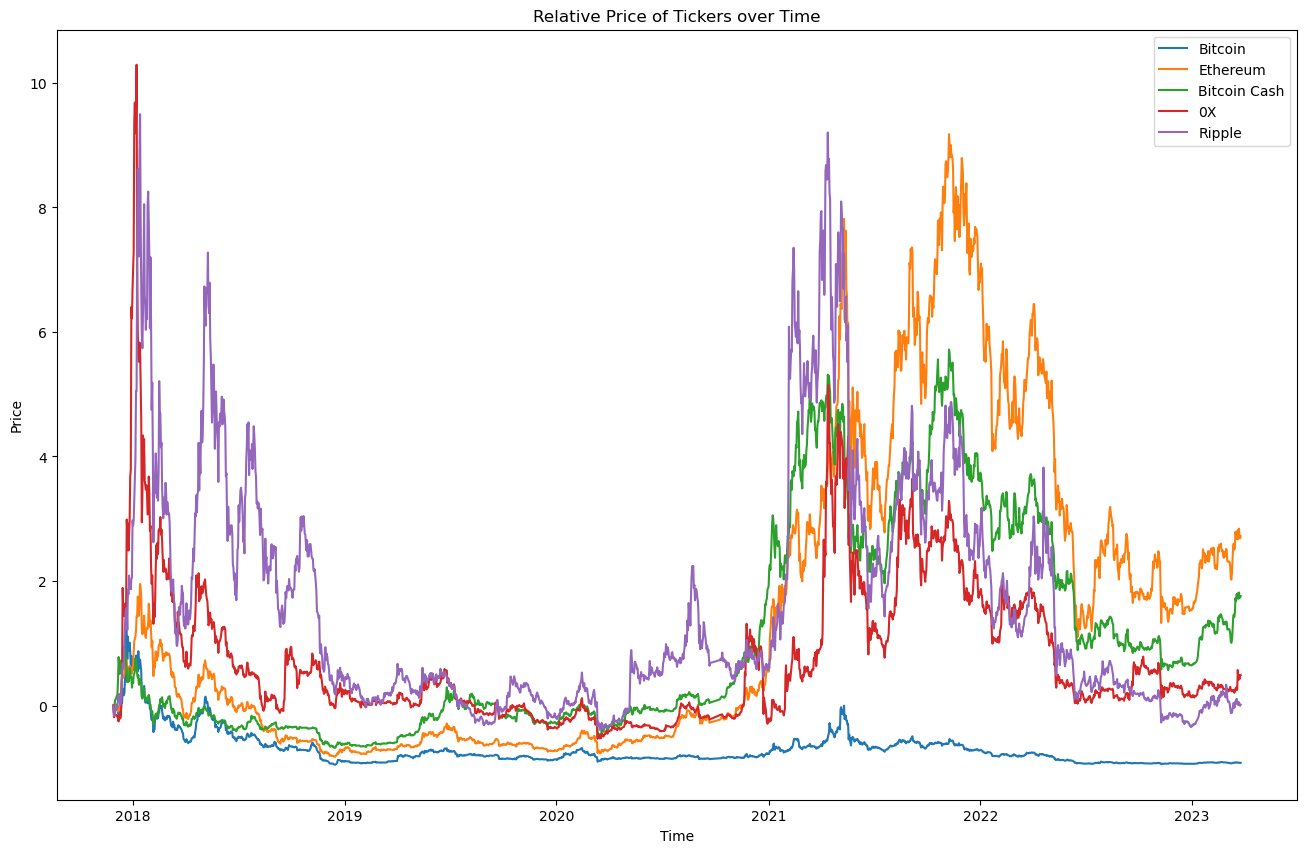

In [51]:
def plot_ticker_data(df, tickers, start=None):
    plt.figure(figsize=(16, 10))
    # df = df.query('index > "2021-04-13"')
    if start is not None:
        df = df.query('index > @start') 
    for ticker in tickers:
        
        data = df[ticker] / df[ticker][0] - 1
        plt.plot(data, label=ticker)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Relative Price of Tickers over Time')
    plt.show()
plot_ticker_data(df, ticker_names)

# Slut på chatGPT




## Get inflation data US and SE

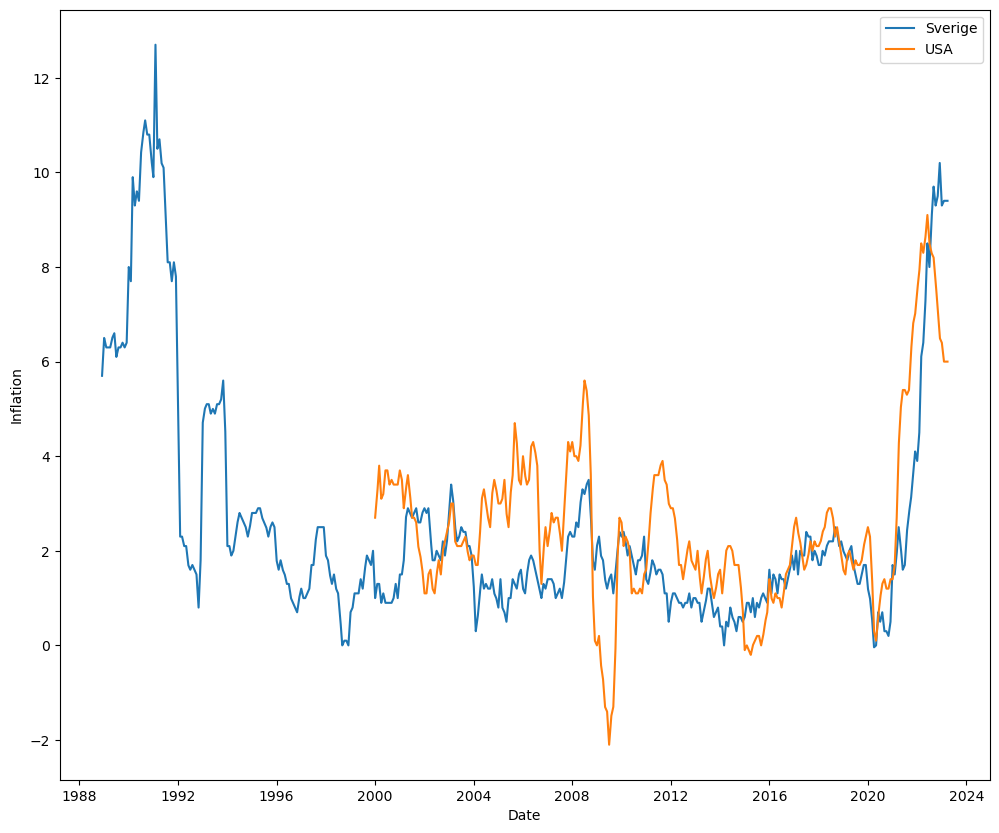

In [52]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def get_inflation_data(graph=False):
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [53]:
list(inflations.columns)

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [54]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


In [55]:
def fill_rolling(df, ticker_name, window):
    """Beräknar rolling trend för en ticker"""

    df[ticker_name+'_tr'] = df[ticker_name].fillna(method='ffill')/30   # Basvärde att räkna från
    df[ticker_name+'_'+str(window)] = df[ticker_name+'_tr'].rolling(window, 1).mean()
    # remove column
    df.drop(ticker_name+'_tr', axis=1, inplace=True)
    
    return df

## get Google Trends Crypto data
Fungerar inte bra - stryker den

In [56]:
def get_google_trend_data(ticker_names):
    # get google trends data
    from pytrends.request import TrendReq

    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10, 25), 
                        retries=2, 
                        backoff_factor=0.1, requests_args={'verify': True})
    df_trend = get_all_dates()
    for ticker_name in ticker_names:
        print(ticker_name)
        pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
        
        df_temp = pytrends.interest_over_time()
        df_temp = df_temp.drop(columns=['isPartial'])
        df_temp.plot()
        df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
        df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
        # df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
        df_trend = fill_rolling(df_trend, ticker_name, 30)
        # df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
        df_trend = fill_rolling(df_trend, ticker_name, 90)
        # df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
        df_trend = fill_rolling(df_trend, ticker_name, 250)
    return df_trend    
if False:
    df_trend = get_google_trend_data(ticker_names)    
    # gruppera kolumnerna per typ av data
    df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]
    df_trend.to_csv('google_trends.csv')
    df_trend.tail()


## skapa alla modellerna

In [57]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [58]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [59]:
display(df_org.isna().sum())
display(df_org.tail())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1166
XRP-USD    1149
dtype: int64

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2023-03-22,27307.437500,1737.717041,126.236031,0.227455,0.422480
2023-03-23,28333.972656,1816.405151,128.812714,0.237676,0.444850
2023-03-24,27493.285156,1752.044800,123.892990,0.229557,0.425902
2023-03-25,27494.707031,1743.764771,125.152679,0.224970,0.444716
2023-03-26,27731.859375,1758.642334,124.713669,0.228400,0.445894


(3113, 5)

In [60]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [61]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [62]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
            
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    predictors += ['day_of_month']
    
    df['day_of_week'] = df.index.dayofweek
    predictors += ['day_of_week']
    
    df['month'] = df.index.month
    predictors += ['month']

    predictors += ['stoch_k']
    # df = df.dropna()
    return df, predictors


### Vi använder XGBoost / catb

Loop öve all tickers och skapa 2 modeller  
    En mot y1 (tomorrow) och en mot y2 (day after tomorrow)  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [63]:
def add_google_trends(df_, df_trend, ticker, predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    predictors.append(ticker_namn + '_goog250')
    
    return df, predictors


##### Generate all xgbModels and save them #####
def old_generate_all_xgbmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=True):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        # df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
                
        predictions_xgb = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json', save)


        print(namn+'2')
        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        # df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_xgb = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        print('predictors: ', predictors)
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors


In [64]:

def train_and_save_model(model, train_data, test_data, predictors, target, model_path, save=True):
    model.fit(train_data[predictors], train_data[target],
              eval_set=[(train_data[predictors], train_data[target]),
                        (test_data[predictors], test_data[target])],
              verbose=False)
    if save:
        model.save_model(model_path)


def generate_all_models(df_org, tickers, horizons, model_type='xgb', save=True, remove=[], ETH_BTC=False, use_inflations=True):
    if model_type == 'xgb':
        model_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                        'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4,
                        'random_state': 2022, 'n_jobs': -1}
        Model = xgb.XGBClassifier
    elif model_type == 'catb':
        model_params = {'iterations': 200, 'learning_rate': 0.005, 'depth': 7,
                        'l2_leaf_reg': 3, 'random_state': 2022, 'verbose': False}
        Model = CatBoostClassifier
    else:
        raise ValueError(
            "Invalid model_type. Accepted values are 'xgb' and 'catb'.")

    precision_list = []

    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        ticker_name = ticker[:3]
        targets = ['y1', 'y2']

        for target in targets:
            print(f'{ticker_name}{target}')
            model = Model(**model_params)

            df, predictors = create_predictors(
                df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)

            if use_inflations:
                df = pd.concat([df, df_inflations], axis=1)
                predictors += list(df_inflations.columns)
                df.dropna(subset=[target], inplace=True)

            if remove != []:
                for col in remove:
                    predictors.remove(col)

            predictions_model = backtest(
                df, target, model, predictors, proba_val=0.55, step=30)
            precision_list.append(
                (f'{ticker_name}{target}', print_results(predictions_model, target)))

            df_imp = pd.DataFrame(model.feature_importances_, columns=[
                                  'importance'], index=predictors).sort_values(by='importance', ascending=False)
            print(df_imp.plot(
                kind='bar', title=f'{ticker_name}{target}', figsize=(18, 10)).get_figure())
            plt.show()

            test_index = int(df.shape[0] * 0.8)
            train_data = df.iloc[:test_index].copy()
            test_data = df.iloc[test_index:].copy()

            model = Model(**model_params)

            model_path = f'{model_type}_{ticker_name}_{target}.json'
            train_and_save_model(model, train_data, test_data,
                                 predictors, target, model_path, save)

    return precision_list, predictors


In [65]:

# TODO: Kolla om inflation skall ha en ratio eller inte
# TODO: ta bort absoluta värdet från predictors
# TODO: KOlla om man inte kan använda sammam create_predictors som tickers
# TODO: Jämför CatBoostClassifier med XGBoostClassifier
# TODO: Ta bort parametern remove från generate_all_models()

##### Generate all catModels and save them #####

#####################################
#####    OBS OBS OBS OBS OBS    #####
#####    DENNA ÄR INTE KLAR     #####
#####################################
def old_generate_all_catmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=False):
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')

    
    cat_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        # df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_cat, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json')


        print(namn+'2')
        target='y2'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        # df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_cat, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors

In [66]:
###### Testar enbart en ticker ######

ticker=tickers[2]
print(ticker)
target='y1'
horizons = [2, 5, 30, 60, 250]

df_inflations = get_inflation_data(graph=False)
df_test, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=True)
# df_test, predictors = add_google_trends(df_test, df_trend, ticker, predictors)

df_test = pd.concat([df_test, df_inflations], axis=1)
predictors += list(df_inflations.columns)
df_test.dropna(subset=['y1'], inplace=True)
    


BCH-USD


In [67]:
print('df_test för '+ticker)
df_test[predictors] 

df_test för BCH-USD


,ETH_BTC_ratio,ETH_BTC_lag1,ETH_BTC_lag2,BCH_BTC_ratio,BCH_BTC_lag1,BCH_BTC_lag2,BCH_ETH_ratio,BCH_ETH_lag1,BCH_ETH_lag2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_30,Trend_30,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,day_of_month,day_of_week,month,stoch_k,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250
2014-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,2.0,9.0,NaN,1.7,0.46,1.748774,0.449058,1.792444,0.478889,1.776903,0.443240
2014-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,3.0,9.0,NaN,1.7,0.47,1.745290,0.447497,1.788704,0.476630,1.777948,0.443520
2014-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,4.0,9.0,NaN,1.7,0.48,1.741935,0.446112,1.785000,0.474556,1.779058,0.443840
2014-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,5.0,9.0,NaN,1.7,0.49,1.738710,0.444903,1.781333,0.472667,1.780232,0.444200
2014-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,6.0,9.0,NaN,1.7,0.50,1.735613,0.443871,1.777704,0.470963,1.781471,0.444600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22,0.063635,0.064125,0.062495,0.004623,0.004772,0.004704,0.072645,0.074421,0.075262,0.968447,130.348888,0.958167,131.747444,0.981506,128.614608,0.967570,130.467142,1.055430,119.606221,22.0,2.0,3.0,0.482827,6.0,9.40,6.055914,9.386022,6.112724,9.386738,7.018510,9.453052
2023-03-23,0.064107,0.063635,0.064125,0.004546,0.004623,0.004772,0.070916,0.072645,0.074421,1.010103,127.524372,0.981445,131.248079,1.005823,128.066930,0.987297,130.470113,1.076282,119.683079,23.0,3.0,3.0,0.310474,6.0,9.40,6.051613,9.387097,6.107957,9.384946,7.008897,9.456716
2023-03-24,0.063726,0.064107,0.063635,0.004506,0.004546,0.004623,0.070713,0.070916,0.072645,0.980532,126.352852,0.961891,128.801479,0.971959,127.467263,0.950743,130.311695,1.034717,119.736112,24.0,4.0,3.0,0.067885,6.0,9.40,6.047484,9.388129,6.103226,9.383477,6.999310,9.460252
2023-03-25,0.063422,0.063726,0.064107,0.004552,0.004506,0.004546,0.071772,0.070713,0.070916,1.005058,124.522835,0.979966,127.711232,0.985387,127.008649,0.960796,130.259302,1.045115,119.750191,25.0,5.0,3.0,0.099710,6.0,9.40,6.043527,9.389118,6.098530,9.382330,6.989748,9.463658


In [68]:
print('Kollar kolumner för',ticker)
print(predictors)
print(df_test.columns)
print(df_test.shape)

my_date='2023-03-01'
row_number = df_test.index.get_loc(my_date)
print('row_number=',row_number,'\n',df_test.iloc[row_number])


Kollar kolumner för BCH-USD
['ETH_BTC_ratio', 'ETH_BTC_lag1', 'ETH_BTC_lag2', 'BCH_BTC_ratio', 'BCH_BTC_lag1', 'BCH_BTC_lag2', 'BCH_ETH_ratio', 'BCH_ETH_lag1', 'BCH_ETH_lag2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month', 'stoch_k', 'US_inflation', 'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250']
Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD', 'ETH_BTC_ratio', 'ETH_BTC_lag1', 'ETH_BTC_lag2', 'BCH_BTC_ratio', 'BCH_BTC_lag1', 'BCH_BTC_lag2', 'BCH_ETH_ratio', 'BCH_ETH_lag1',
       'BCH_ETH_lag2', 'stoch_k', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month', 'US_inflation

            US_inflation  SE_inflation
date                                  
2023-01-01      6.400000      9.300000
2023-01-02      6.387097      9.303226
2023-01-03      6.374194      9.306452
2023-01-04      6.361290      9.309677
2023-01-05      6.348387      9.312903
2023-01-06      6.335484      9.316129
2023-01-07      6.322581      9.319355
2023-01-08      6.309677      9.322581
2023-01-09      6.296774      9.325806
2023-01-10      6.283871      9.329032
2023-01-11      6.270968      9.332258
2023-01-12      6.258065      9.335484
2023-01-13      6.245161      9.338710
2023-01-14      6.232258      9.341935
2023-01-15      6.219355      9.345161
2023-01-16      6.206452      9.348387
2023-01-17      6.193548      9.351613
2023-01-18      6.180645      9.354839
2023-01-19      6.167742      9.358065
2023-01-20      6.154839      9.361290
2023-01-21      6.141935      9.364516
2023-01-22      6.129032      9.367742
2023-01-23      6.116129      9.370968
2023-01-24      6.103226 

<Axes: xlabel='date'>

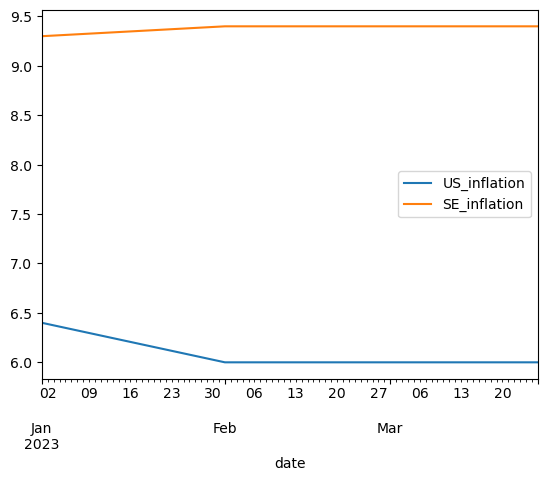

In [69]:
# df_inflations[['US_inflation','SE_inflation']]
print(df_inflations.loc['2023-01-01':'2023-12-31',['US_inflation','SE_inflation']])
# plot only year=2023
df_inflations.loc['2023-01-01':'2023-12-31',['US_inflation','SE_inflation']].plot()


BTCy1
last date 2023-03-26
Fördelning av y1: 1 vs 0:
1.0    0.537959
0.0    0.462041
Name: y1, dtype: float64
y1   Predictions
1.0  0              1051
0.0  0               948
1.0  1               430
0.0  1               324
dtype: int64
Precision:	0.5703
Figure(1800x1000)


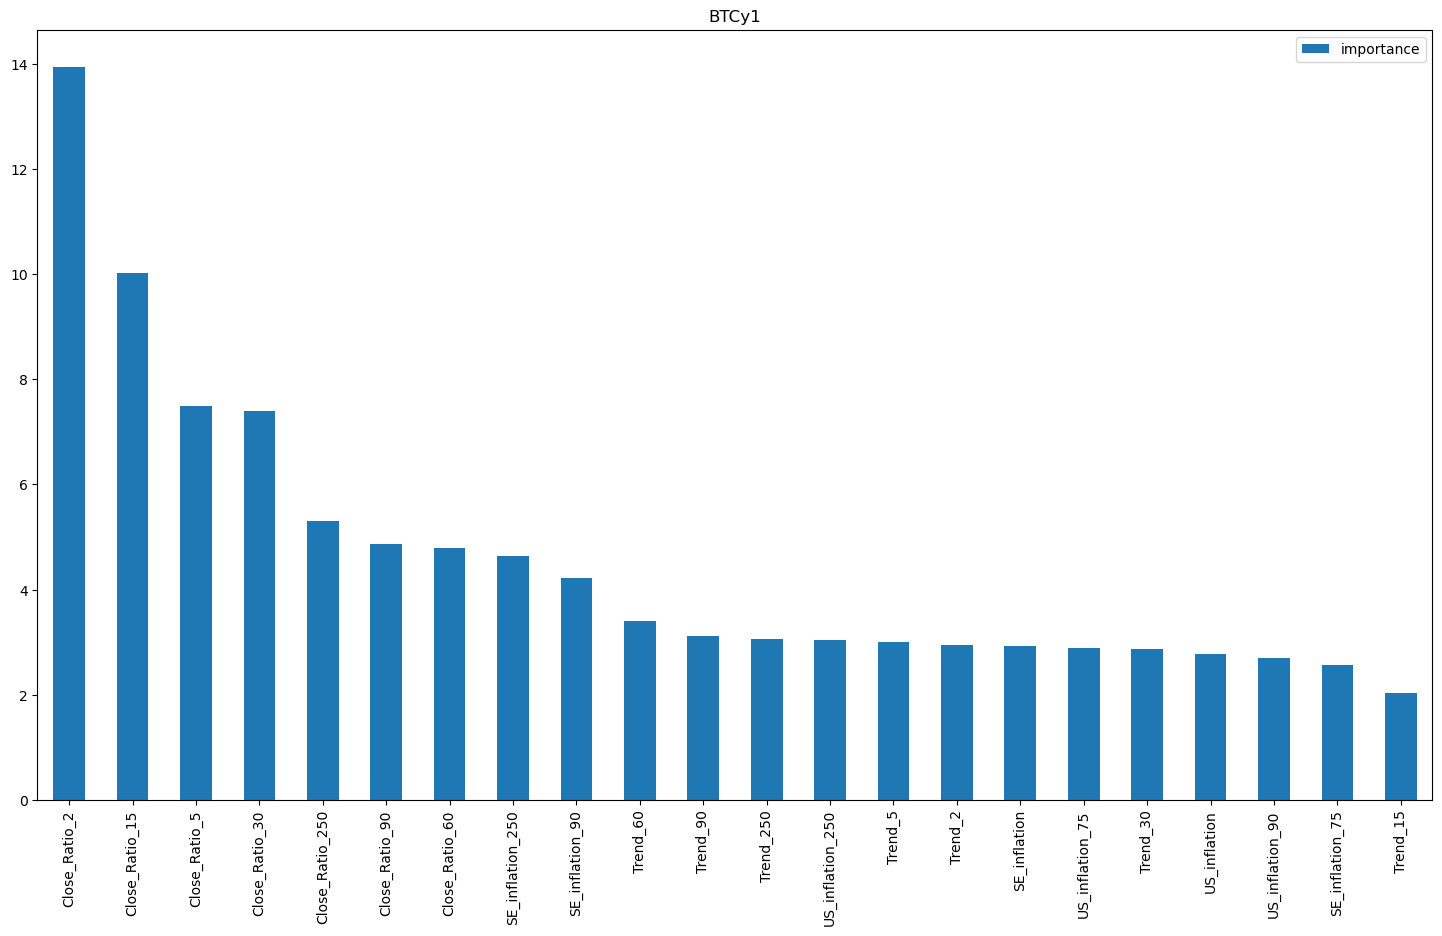

BTCy2
last date 2023-03-26
Fördelning av y2: 1 vs 0:
1.0    0.555394
0.0    0.444606
Name: y2, dtype: float64
y2   Predictions
1.0  0              965
0.0  0              813
1.0  1              564
0.0  1              411
dtype: int64
Precision:	0.5785
Figure(1800x1000)


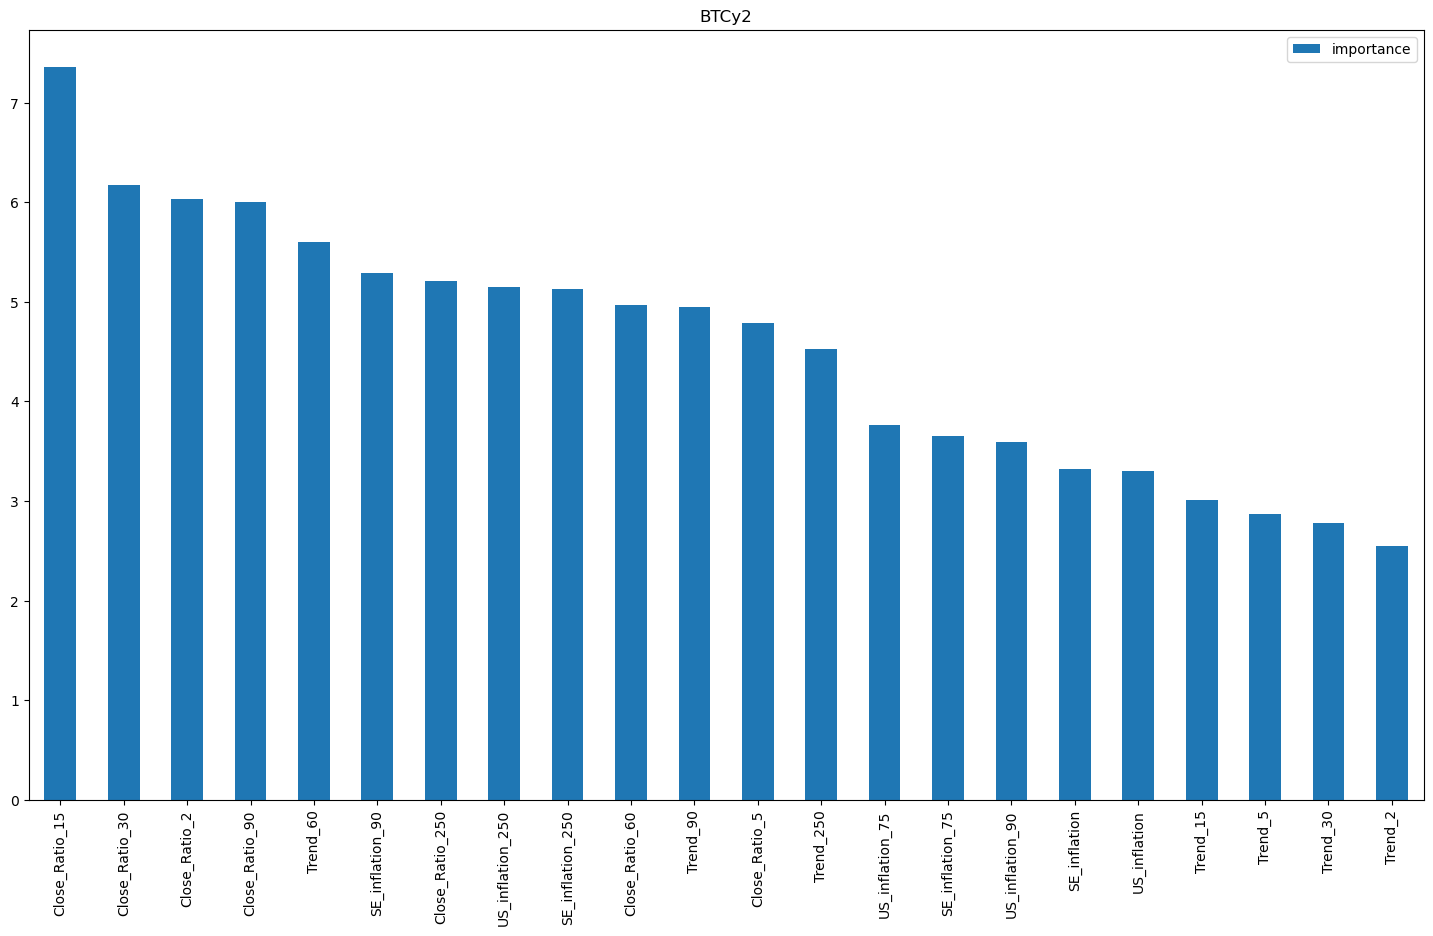

ETHy1
last date 2023-03-26


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/target_converter.cpp:375: Target contains only one unique value

In [74]:
horizons=[2,5,15,30,60,90,250]
# precision_list, predictors = generate_all_xgbmodels(df_org, 
#                                                     tickers, 
#                                                     horizons=horizons, 
#                                                     save=True, 
#                                                     remove=['month','stoch_k','day_of_week','day_of_month'], 
#                                                     use_inflations=True)

precision_list, predictors = generate_all_models(df_org, 
                                                tickers, 
                                                horizons=horizons,
                                                model_type='catb', 
                                                save=True, 
                                                remove=['month', 'stoch_k', 'day_of_week', 'day_of_month'], 
                                                ETH_BTC=False, 
                                                use_inflations=True)


'bad precision:'

,precision
BCHy2,0.495025
XRPy2,0.492683
ZRXy2,0.469333
ETHy2,0.462777


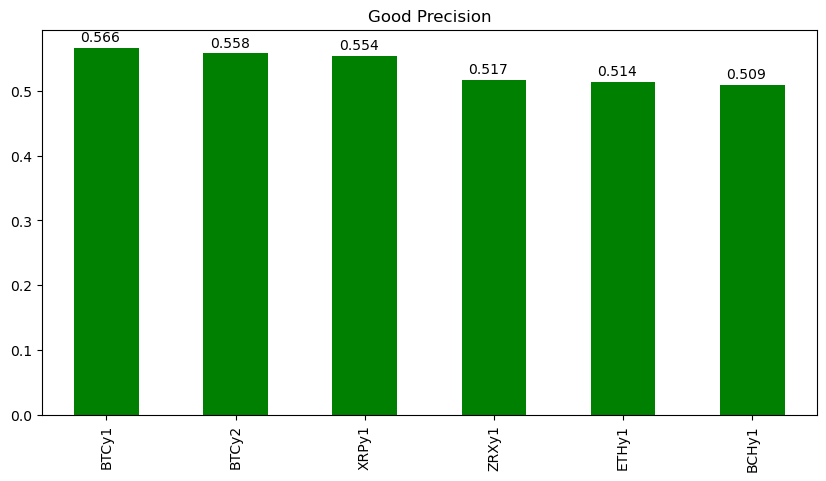

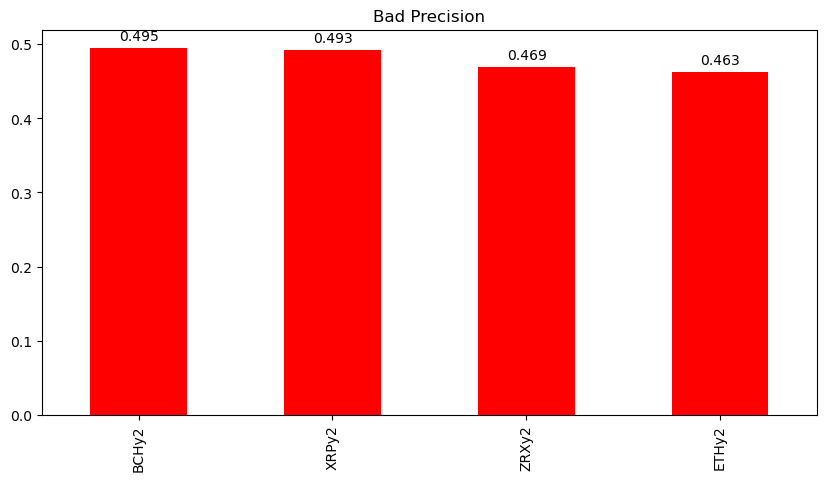

In [71]:

df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green', legend=False)
# plot values in bars
for i, v in enumerate(df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).values):
    plt.text(i-0.2, v+0.01, str(round(v[0],3)))
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar',  figsize=(10,5), title='Bad Precision',color='red', legend=False)
    # plot values in bars
    for i, v in enumerate(df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).values):
        plt.text(i-0.1, v+0.01, str(round(v[0],3)))
except IndexError:
    print('No bad precision!')

display('bad precision:',df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False))
df_precision.to_csv('precision_lags_and_ratio_no_month_stochk_15_90.csv')
# df

In [72]:
# sort the list
precision_list.sort(key=lambda x: x[1], reverse=True)
precision_list
df_precision

,precision
BTCy1,0.566197
BTCy2,0.557930
ETHy1,0.514151
ETHy2,0.462777
BCHy1,0.509346
BCHy2,0.495025
ZRXy1,0.516517
ZRXy2,0.469333
XRPy1,0.554479
XRPy2,0.492683


Figure(1800x1000)


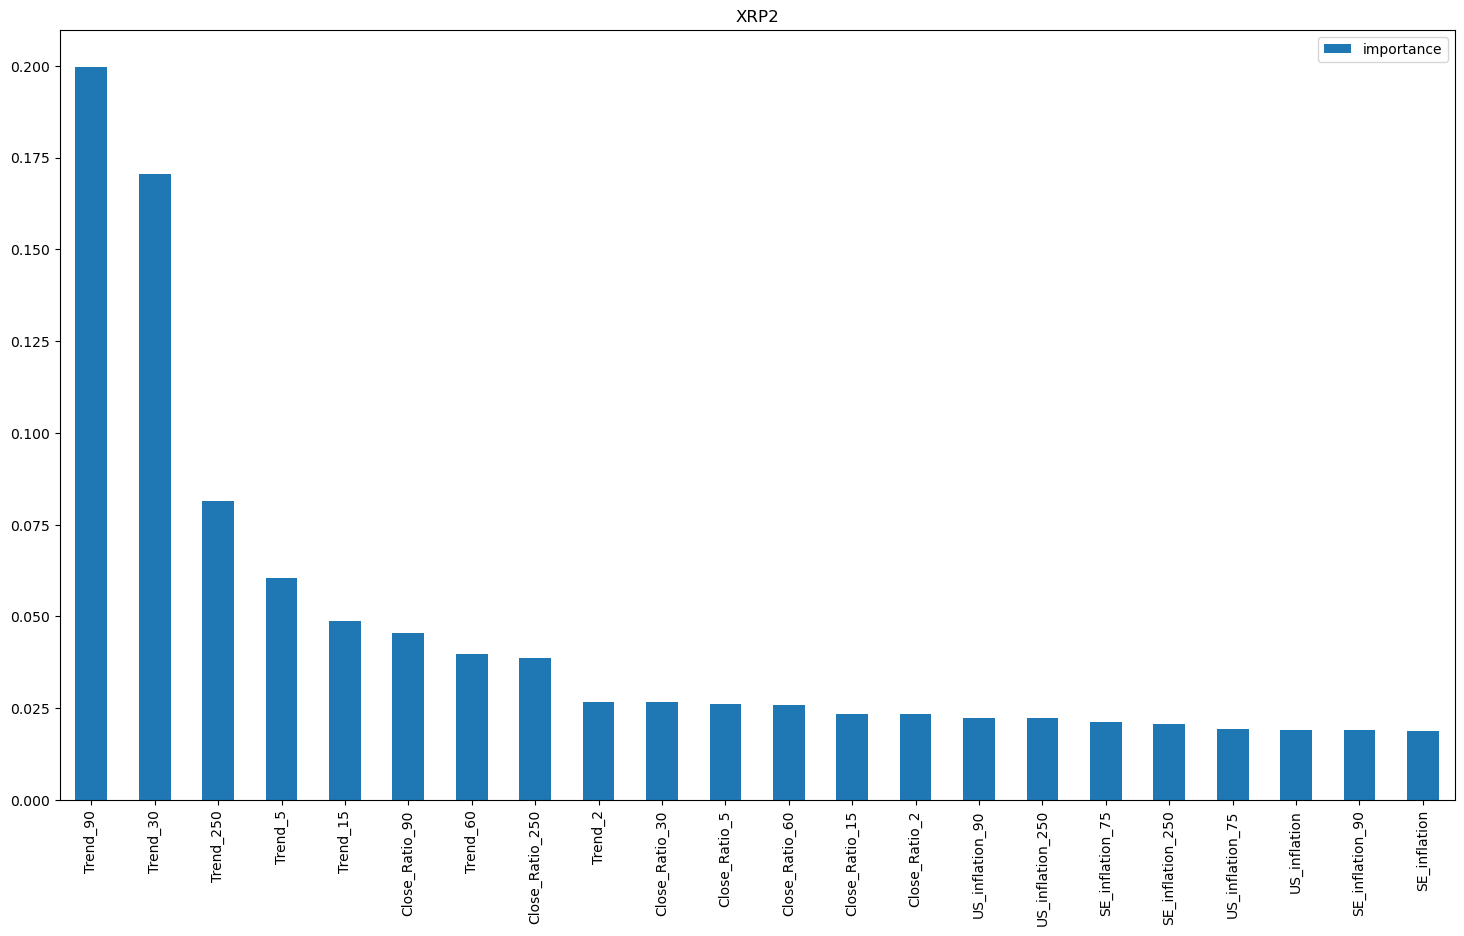

In [73]:
# horizons = [2, 5, 15, 30, 60, 90, 250]
# df, predictors = add_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)
# df['BTC_lag1'] = df['BTC-USD'].shift(1)
# df['BTC_lag_2'] = df['BTC-USD'].shift(2)
# df['ETH_lag_1'] = df['ETH-USD'].shift(1)
# df['ETH_lag_2'] = df['ETH-USD'].shift(2)
# display(predictors)
# df[predictors]
model = xgb.XGBClassifier()
model.load_model('XRP_y2.json')
df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
print(df_imp.plot(kind = 'bar', title='XRP'+'2', figsize = (18, 10)).get_figure())
plt.show()
        

# Bryt här. Det finns ett plotly-exempel sist

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [ ]:
horizons=[2,5,15,30,60,90,250]
df, predictors = create_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


### Test plotly

In [ ]:
df.columns

In [ ]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

In [ ]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb)

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'comb' is a DataFrame with the index as the x-axis values
x_values = comb.index

# Create a plotly line chart
fig = go.Figure()

# Add lines for each cryptocurrency with custom colors
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BTC-USD'], mode='lines', name='BTC-USD', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ETH-USD'], mode='lines', name='ETH-USD', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BCH-USD'], mode='lines', name='BCH-USD', line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ZRX-USD'], mode='lines', name='ZRX-USD', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['XRP-USD'], mode='lines', name='XRP-USD', line=dict(color='purple', width=2)))

# Set the chart title
fig.update_layout(title='Price')

# Set the chart size
fig.update_layout(height=800, width=1000)

fig.show()
